In [921]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

$\frac{\partial u}{\partial t} - \frac{\partial^2u}{\partial x^2} = 0$,      $0\leq x \leq \pi,t\geq 0$  
$u(x,0) = \sin(x)$ :$IC$  
$u(0,t) = u(\pi, t) = 0$, $t\geq 0$ :$BC$

# Setting up

In [922]:
t_0, t_n = 0, 5
x_0, x_n = 0, np.pi
gt_fn = lambda x, t: np.sin(x) * np.exp(-t)
by_x = True

In [923]:
def make_hx(h_t):
    return np.sqrt(2*h_t) * 1.1

def make_ht(h_x, maximum=False):
    fraction = 1.0 if maximum else 0.9
    return 0.5 * np.power(h_x, 2) * fraction

In [924]:
def generate_hs(span = 0.5, min_h = 0.05):
    search_resolution = 0.05  
    max_h = min_h + span
    hs = np.linspace(min_h, max_h, int((max_h - min_h) / search_resolution) + 1)
    make = make_ht if by_x else make_hx
    other_hs = [make(h) for h in hs]
    
    return (hs, other_hs) if by_x else (other_hs, hs)


In [925]:
def make_L(n_x):
    L = np.eye(n_x) * 2 - np.eye(n_x, k=1) - np.eye(n_x, k=-1)
    return L

def make_A_fwd_euler(h_x, h_t, n_x):
    """Returns the matrix A to be multiplied to u at each time step for next time step.
        u(k+1) = A u(k)"""
    L = make_L(n_x)
    return (np.eye(n_x) - (h_t/(h_x**2))*L)

def calc_u_grid(h_x, h_t, x_grid, t_grid, make_A):
    """ Compute the u grid.
        returns a 2D array where each column is the u values at a time step. (n_x, n_t)"""
    n_x = len(x_grid)
    A = make_A(h_x, h_t, n_x)
    
    u_grid = [np.sin(x_grid)] # starting from inital condition
    for _ in t_grid:
        last_u = u_grid[-1]
        u_grid.append(A @ last_u)
    return np.column_stack(u_grid[1:]) # removing initial condition as it is not part of our solution

def get_solution(h_x, h_t, make_A):
    x_grid = np.linspace(x_0, x_n, round((x_n - x_0)/h_x) + 1)[1:-1]
    t_grid = np.linspace(t_0, t_n, round((t_n - t_0)/h_t)+1)[1:]
    print(f"h_t: {h_t:.4f}, h_x: {h_x:.4f} grid: {x_grid.shape[0]} x {t_grid.shape[0]}")
    u_grid = calc_u_grid(h_x, h_t, x_grid, t_grid, make_A)
    # print(f"grid: {x_grid.shape} x {t_grid.shape}")
    return x_grid, t_grid, u_grid, h_x, h_t




In [926]:
def calc_solutions_accross_hs(hxs, hts, make_A):
    return [get_solution(h_x, h_t, make_A) for h_x, h_t in tqdm(zip(hxs, hts))]

# grid calculation

In [927]:
hxs, hts = generate_hs()
print(f"hxs: {hxs}")
print(f"hts: {hts}")
u_grids = calc_solutions_accross_hs(hxs, hts, make_A_fwd_euler)

hxs: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]
hts: [0.0011250000000000003, 0.004500000000000001, 0.010125000000000004, 0.018000000000000006, 0.028125, 0.0405, 0.055125000000000014, 0.07200000000000002, 0.09112500000000001, 0.1125, 0.13612500000000002]


11it [00:00, 203.52it/s]

h_t: 0.0011, h_x: 0.0500 grid: 62 x 4444
h_t: 0.0045, h_x: 0.1000 grid: 30 x 1111
h_t: 0.0101, h_x: 0.1500 grid: 20 x 494
h_t: 0.0180, h_x: 0.2000 grid: 15 x 278
h_t: 0.0281, h_x: 0.2500 grid: 12 x 178
h_t: 0.0405, h_x: 0.3000 grid: 9 x 123
h_t: 0.0551, h_x: 0.3500 grid: 8 x 91
h_t: 0.0720, h_x: 0.4000 grid: 7 x 69
h_t: 0.0911, h_x: 0.4500 grid: 6 x 55
h_t: 0.1125, h_x: 0.5000 grid: 5 x 44
h_t: 0.1361, h_x: 0.5500 grid: 5 x 37


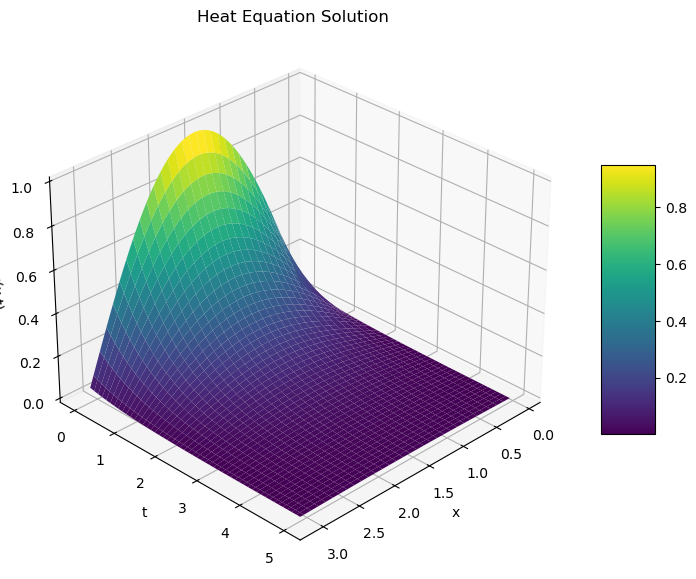

In [928]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_solution_3d(x_axis, t_axis, u_grid):
    """
    Plot 3D surface of solution (interactive).
    
    Args:
        x_axis: 1D array of x values
        t_axis: 1D array of t values
        u_grid: 2D array of shape (len(x_axis), len(t_axis))
    """
    X, T = np.meshgrid(x_axis, t_axis, indexing='ij')
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, u_grid, cmap='viridis')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('Heat Equation Solution')
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()

# Usage with your data:
x_grid, t_grid, u_grid, h_x, h_t = u_grids[0]  # pick a solution
plot_solution_3d(x_grid, t_grid, u_grid)

# Error calculation setup

In [929]:
def eval_fn(x_grid, t_grid, fn):
    # print(f"x_grid: {x_grid}")
    return np.array([
        [fn(x, t) for t in t_grid]
    for x in x_grid])
    # print(f"u shape: {u_grid.shape}")


def relative_error(x_grid, t_grid, u_grid, fn):
    gt_samples = eval_fn(x_grid, t_grid, fn)
    errors = u_grid - gt_samples
    err_norm = np.linalg.norm(errors, axis=0)
    solution_norm = np.linalg.norm(gt_samples, axis=0)
    # print(f"u norm: {solution_norm}, err : {err_norm}")
    # print(f"div: {err_norm / solution_norm}")
    # print(f"gt norm: {np.linalg.norm(gt_samples)}")
    return err_norm / solution_norm

In [930]:
def calc_rel_err_under(u_grids):
    err_grids = []
    for s in u_grids:
        x_grid, t_grid, u_grid, h_x, h_t = s
        rel_err_vec = relative_error(x_grid, t_grid, u_grid, gt_fn)
        infinte_norm = np.linalg.norm(rel_err_vec, ord=np.inf)

        err_grids.append((x_grid, t_grid, u_grid, h_x, h_t, infinte_norm))
        # print(f"h_x: {h_x}, h_t: {h_t} max: {infinte_norm}")

    return err_grids

def find_rel_err_under(err_grids, percent=0.02):
    filtered_list = list(filter(lambda s: s[-1] <= percent, err_grids))
    return min(filtered_list, key=lambda s: s[-3])


In [931]:
def plot_errs_vs_hs(hs, errs, by_x=True):
    plt.figure(figsize=(6,4))
    plt.plot(hs, errs, '-o')

    # plt.xticks(h_ts)

    # plt.yticks(errs)
    axis ='h_x' if by_x else 'h_t'
    plt.xlabel(axis)
    plt.ylabel('max relative error (inf norm)')
    plt.title(f'Error vs time step {axis}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Relative error Calculation

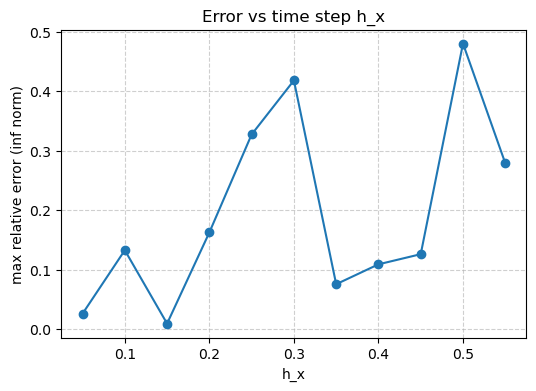

In [932]:
u_grids_err = calc_rel_err_under(u_grids)

def plot_err_across_search_domain(u_grids_err):
    hs = [h_x if by_x else h_t for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    errs = [err for x_grid, t_grid, u_grid, h_x, h_t, err in u_grids_err]
    plot_errs_vs_hs(hs, errs)

plot_err_across_search_domain(u_grids_err)


============== Found error under 0.02 ==============
h_x: 0.15000000000000002, h_t: 0.010125000000000004, error: 0.009099133405359472


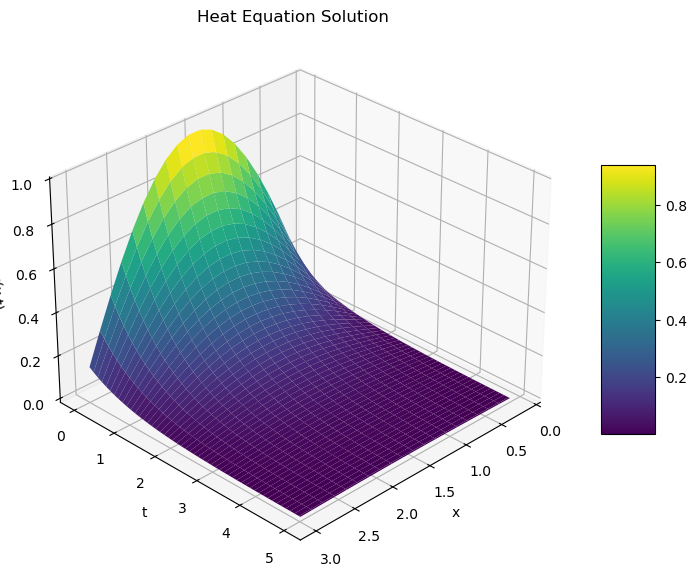

In [933]:
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print("============== Found error under 0.02 ==============")
print(f"h_x: {acc_h_x}, h_t: {acc_h_t}, error: {err}")
plot_solution_3d(acc_x, acc_t, acc_u)

calculating solutions:


3it [00:00, 114.25it/s]


h_t: 0.0025, h_x: 0.0783 grid: 39 x 1975
h_t: 0.0051, h_x: 0.1107 grid: 27 x 988
h_t: 0.0101, h_x: 0.1565 grid: 19 x 494
calculating relative error:


100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


hts_0: [0.002531250000000001, 0.005062500000000002, 0.010125000000000004]
errs_0: [0.03733040745196714, 0.13717965647897817, 0.05082253508989557]


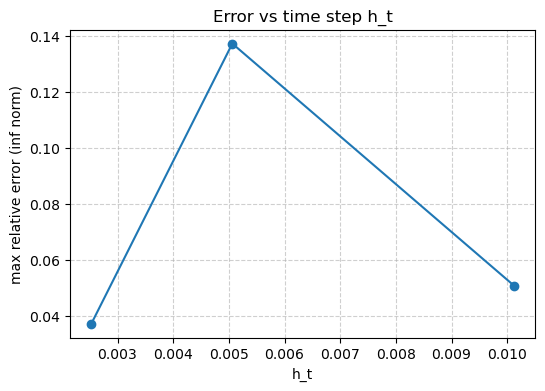

0.37048157426814793
3.6747430805700847


In [934]:

ht0s = [acc_h_t / 4, acc_h_t / 2, acc_h_t]
hx0s = [make_hx(ht0) for ht0 in ht0s]

print(f"calculating solutions:")
u_grids_0 = [get_solution(h_x, h_t, make_A_fwd_euler) for h_x, h_t in tqdm(zip(hx0s, ht0s))]

print(f"calculating relative error:")
errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in tqdm(u_grids_0)]
print(f"hts_0: {ht0s}")
print(f"errs_0: {errs_0}")

plot_errs_vs_hs(ht0s, errs_0, by_x=False)
print(errs_0[-1] / errs_0[-2])
print(errs_0[-2] / errs_0[-3])

# 4.2

In [935]:
def test_higher_ht(acc_h_x, higher_h_t):
    x_grid, t_grid, u_grid, h_x, h_t = get_solution(acc_h_x, higher_h_t, make_A_fwd_euler)
    gt = eval_fn(x_grid, t_grid, gt_fn)
    err_grid = u_grid - gt
    errs = np.linalg.norm(err_grid, axis=0)
    return t_grid, errs

def plot_errs_vs_t(errs, t, log_scale=False):
    if isinstance(errs, list):
        for i in range(len(errs)):
            plt.plot(t[i], errs[i], '-', label=f'factor {i+1}')
        plt.legend()
    else:
        plt.plot(t, errs, '-')

    # plt.xticks(h_ts)

    # plt.yticks(errs)
    if(log_scale):  
        plt.yscale('log')
    plt.xlabel('t')
    plt.ylabel('||e^(k)||')
    plt.title(f'Error vs time ')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

h_t: 0.0152, h_x: 0.1500 grid: 20 x 329


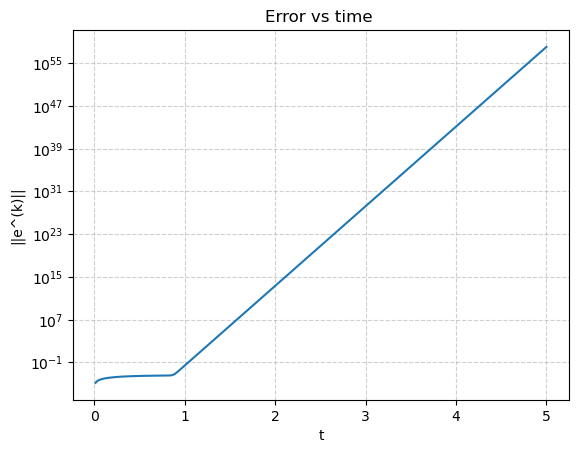

In [936]:
higher_ht0 = acc_h_t * 1.5
t_grid, errs = test_higher_ht(acc_h_x, higher_ht0)
plot_errs_vs_t(errs, t_grid, log_scale=True)



# 4.3

In [937]:
def make_A_bwd_euler(h_x, h_t, n_x):
    """Returns the matrix A to be multiplied to u at each time step for next time step.
        u(k+1) = A u(k)"""
    L = make_L(n_x)
    return np.linalg.inv(np.eye(n_x) + (h_t/(h_x**2))*L)

In [938]:
hxs, hts = generate_hs()
print(f"hxs: {hxs}")
print(f"hts: {hts}")
u_grids = calc_solutions_accross_hs(hxs, hts, make_A_bwd_euler)

hxs: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55]
hts: [0.0011250000000000003, 0.004500000000000001, 0.010125000000000004, 0.018000000000000006, 0.028125, 0.0405, 0.055125000000000014, 0.07200000000000002, 0.09112500000000001, 0.1125, 0.13612500000000002]


11it [00:00, 147.34it/s]

h_t: 0.0011, h_x: 0.0500 grid: 62 x 4444
h_t: 0.0045, h_x: 0.1000 grid: 30 x 1111
h_t: 0.0101, h_x: 0.1500 grid: 20 x 494
h_t: 0.0180, h_x: 0.2000 grid: 15 x 278
h_t: 0.0281, h_x: 0.2500 grid: 12 x 178
h_t: 0.0405, h_x: 0.3000 grid: 9 x 123
h_t: 0.0551, h_x: 0.3500 grid: 8 x 91
h_t: 0.0720, h_x: 0.4000 grid: 7 x 69
h_t: 0.0911, h_x: 0.4500 grid: 6 x 55
h_t: 0.1125, h_x: 0.5000 grid: 5 x 44
h_t: 0.1361, h_x: 0.5500 grid: 5 x 37


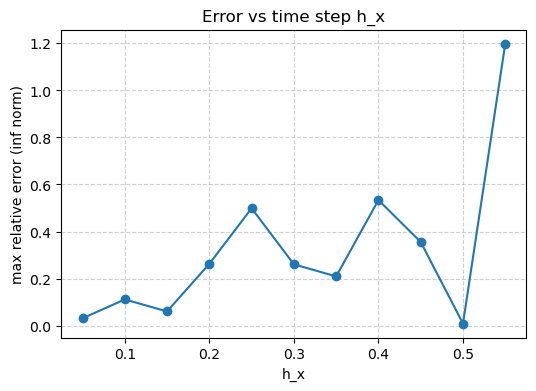

============== Found error under 0.02 ==============
h_x: 0.5, h_t: 0.1125, error: 0.009087989397592543


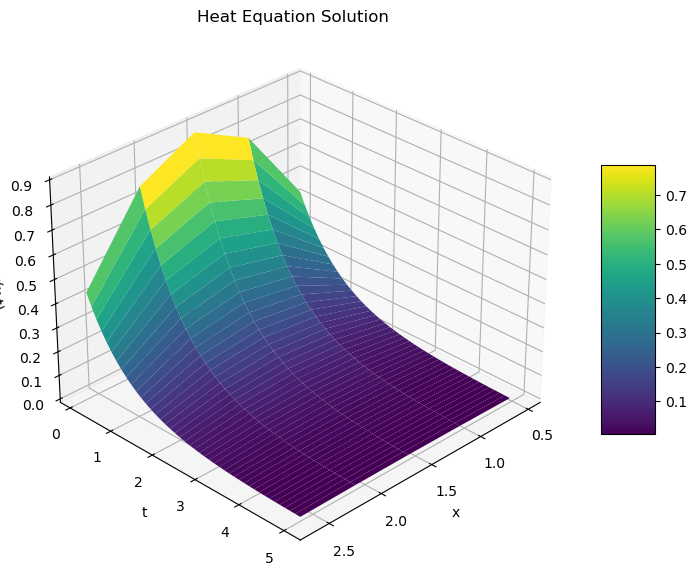

In [939]:
u_grids_err = calc_rel_err_under(u_grids)
plot_err_across_search_domain(u_grids_err)
acc_x, acc_t, acc_u, acc_h_x, acc_h_t, err = find_rel_err_under(u_grids_err)
print("============== Found error under 0.02 ==============")
print(f"h_x: {acc_h_x}, h_t: {acc_h_t}, error: {err}")
plot_solution_3d(acc_x, acc_t, acc_u)

calculating solutions:


3it [00:00, 822.14it/s]


h_t: 0.0281, h_x: 0.2609 grid: 11 x 178
h_t: 0.0563, h_x: 0.3690 grid: 8 x 89
h_t: 0.1125, h_x: 0.5218 grid: 5 x 44
calculating relative error:


100%|██████████| 3/3 [00:00<00:00, 209.48it/s]

hts_0: [0.028125, 0.05625, 0.1125]
errs_0: [0.08102478898734095, 0.5680129928932931, 0.15060988775201517]


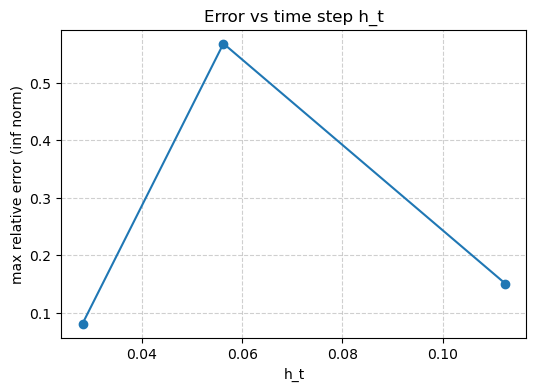

0.26515218777805094
7.010360656194213


In [940]:
ht0s = [acc_h_t / 4, acc_h_t / 2, acc_h_t]
hx0s = [make_hx(ht0) for ht0 in ht0s]

print(f"calculating solutions:")
u_grids_0 = [get_solution(h_x, h_t, make_A_fwd_euler) for h_x, h_t in tqdm(zip(hx0s, ht0s))]

print(f"calculating relative error:")
errs_0 = [np.linalg.norm(relative_error(x_grid, t_grid, u_grid, gt_fn), ord=np.inf) for x_grid, t_grid, u_grid, h_x, h_t in tqdm(u_grids_0)]
print(f"hts_0: {ht0s}")
print(f"errs_0: {errs_0}")

plot_errs_vs_hs(ht0s, errs_0, by_x=False)
print(errs_0[-1] / errs_0[-2])
print(errs_0[-2] / errs_0[-3])

# 4.4

h_t: 0.0681, h_x: 0.3690 grid: 8 x 73
h_t: 0.1361, h_x: 0.3690 grid: 8 x 37
h_t: 0.2042, h_x: 0.3690 grid: 8 x 24
h_t: 0.2723, h_x: 0.3690 grid: 8 x 18
h_t: 0.3403, h_x: 0.3690 grid: 8 x 15
h_t: 0.4084, h_x: 0.3690 grid: 8 x 12
h_t: 0.4764, h_x: 0.3690 grid: 8 x 10
h_t: 0.5445, h_x: 0.3690 grid: 8 x 9


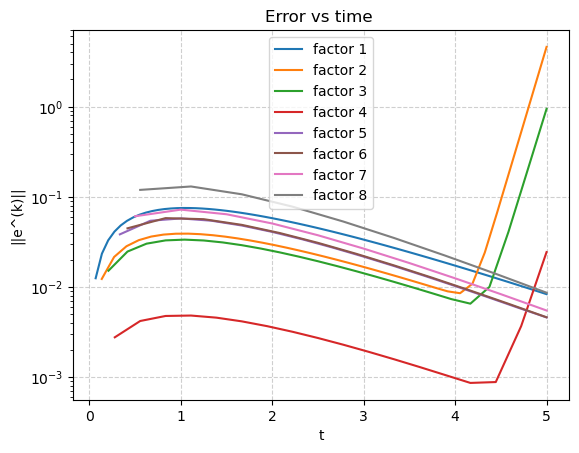

In [941]:
h_x = hx0s[1]
h_t = make_ht(h_x, maximum=True)
factors = list(range(1, 9))

ts_list = []
errs_list = []
for f in factors:
    higher_ht0 = h_t * f
    t_grid, errs = test_higher_ht(h_x, higher_ht0)
    errs_list.append(errs)
    ts_list.append(t_grid)
    
plot_errs_vs_t(errs_list, ts_list, log_scale=True)